In [26]:
#from jqdata import *
from jqdatasdk import *
auth('15336553896','553896')
import numpy as np
import pandas as pd
import datetime as dt
from six import StringIO, BytesIO
from dateutil.parser import parse
import pickle
import seaborn as sns

from pylab import mpl, plt
mpl.rcParams['font.sans-serif'] = ['SimHei']
  
import matplotlib as mpl
import os
import statsmodels.api as sm
import scipy
import talib as tl
import xlrd

load_data={}

#path = '/Macro'
path = 'E:\investment_quant\yihang_try1\TLQUANT\Macro'

class backtest_result():
    def __init__(self,data):
        self.data = data
        self.total_returns = data.iloc[-1]-1
        self.annualized_returns = data.iloc[-1]**(12./len(data))-1
        self.annualized_volatility = data.pct_change().std()*(12.**0.5)
    def Max_Drawback(self):
        net_value=self.data
        max_value=0
        df_tmp=pd.DataFrame(net_value)
        df_tmp.columns=['value']
        for j in range(0,len(net_value),1):
            max_value=max(max_value,df_tmp.ix[j,'value'])
            df_tmp.ix[j,'drawback']=1-df_tmp.ix[j,'value']/max_value
            drawback=df_tmp['drawback'].max()
        return drawback
    def Sharpe(self):
        net_value=self.data
        bench_pct=0.03
        df_tmp=pd.DataFrame(net_value)
        df_tmp.columns=['value']
        df_tmp['pct']=df_tmp['value'].pct_change()
        annual_pct = df_tmp.ix[-1,'value']**(12./len(df_tmp))-1
        sharpe = (annual_pct-bench_pct)/(df_tmp['pct'].std()*12**0.5)
        return sharpe
    def Calmar(self):
        clamar = self.annualized_returns/self.Max_Drawback()
        return clamar

Index(['日期', 'PMI', 'PMI:生产', 'PMI:新订单', 'PMI:新出口订单', 'PMI:进口'], dtype='object')


E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:14: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  


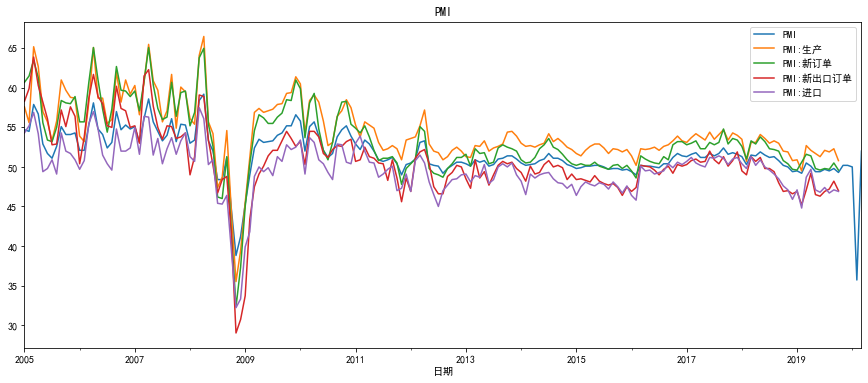

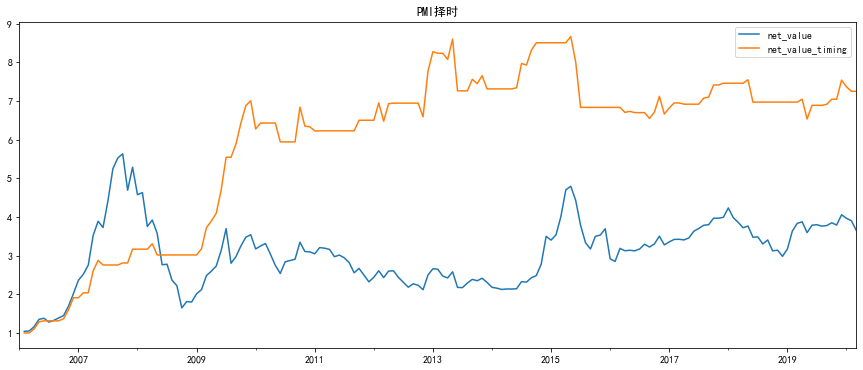

In [5]:
#PMI择时
def read_file(path):
    with open(path, 'rb') as f:
        return f.read()
body=read_file(path+'/PMI组合.xls')
df_boom=pd.read_excel(BytesIO(body))
print (df_boom.columns)
col =u'PMI'
df_boom=df_boom.set_index(u'日期')
df_boom.plot(figsize=(15,6),title='PMI')
n=3
df_boom['position']=(df_boom[col].shift(1).rolling(n).mean()>df_boom[col].shift(2).rolling(n).mean()).astype(float)
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2020-03-31',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0
df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_boom['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='PMI择时')


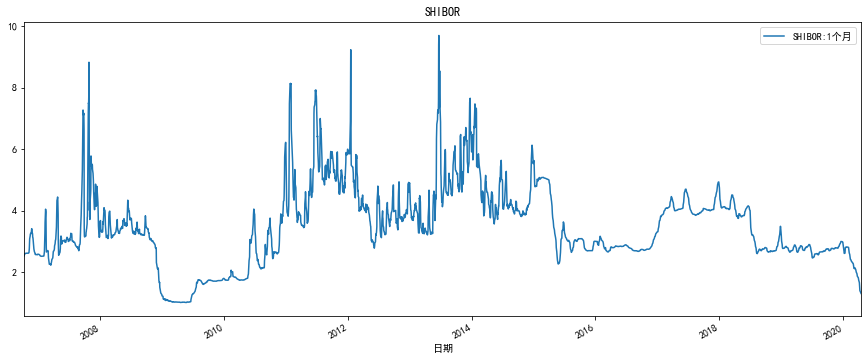

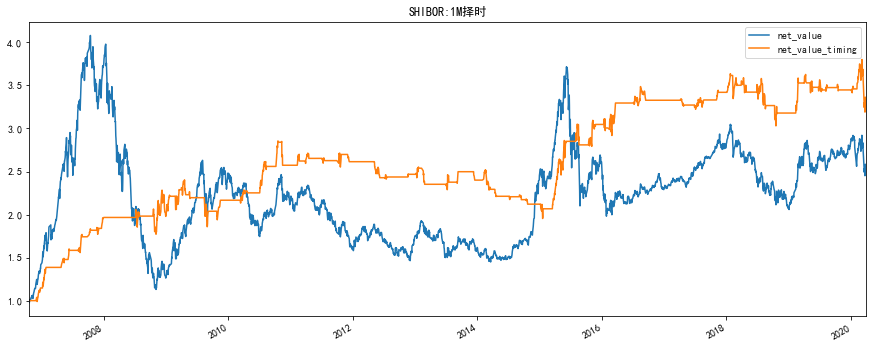

In [9]:
#SHIBOR

body=read_file(path+'/SHIBOR数据.xls')
df_interest=pd.read_excel(BytesIO(body))
col = u'SHIBOR:1个月'
df_interest=df_interest.set_index(u'日期')

df_interest.iloc[:,1:2].plot(figsize=(15,6),title='SHIBOR')
df_interest=df_interest[[col]]
upperband,middleband,lowerband = (tl.BBANDS(df_interest[col].values, timeperiod=12, nbdevup=1.8, nbdevdn=1.8))
# print df_1

df_interest['BBAND_upper']=upperband
df_interest['BBAND_middle']=middleband
df_interest['BBAND_lower']=lowerband

pre_position = 0
for date in df_interest.index:
    if df_interest.loc[date,col]>df_interest.loc[date,'BBAND_middle']:
        df_interest.loc[date,'position']=0
    elif df_interest.loc[date,col]<df_interest.loc[date,'BBAND_lower']:
        df_interest.loc[date,'position']=1.0
    else:
        df_interest.loc[date,'position']=pre_position
    pre_position=df_interest.loc[date,'position']
df_interest['position']=df_interest['position'].shift(1)

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2020-03-31',fields='close')['close']
df_pct['pct']=prices.pct_change()

rate_riskfree = 0
df_pct = pd.concat([df_pct,df_interest],axis=1)['2005-01-01':'2020-03-31'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='SHIBOR:1M择时')

Index(['中债国债到期收益率:1个月', '中债国债到期收益率:3个月', '中债国债到期收益率:6个月', '中债国债到期收益率:3年',
       '中债国债到期收益率:5年', '中债国债到期收益率:10年'],
      dtype='object')


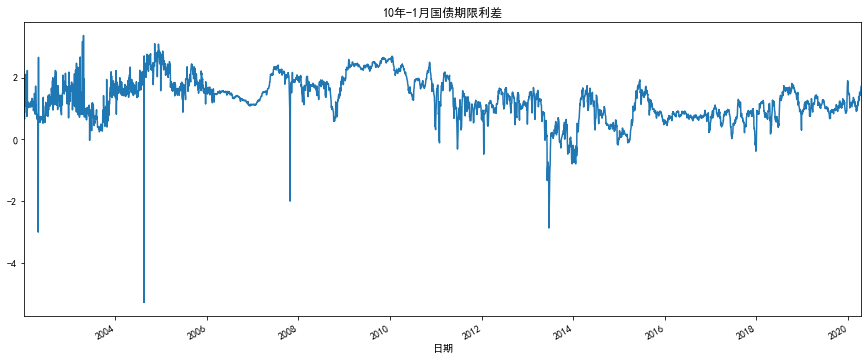

In [10]:
#获取国债期限利差数据
body=read_file(path+'/国债到期收益率.xls')
df_gz=pd.read_excel(BytesIO(body))
df_gz.set_index(u'日期',inplace=True)
print (df_gz.columns)
df_gz=df_gz.fillna(method='ffill')
term_spread_gz = df_gz[u'中债国债到期收益率:10年']-df_gz[u'中债国债到期收益率:1个月']
term_spread_gz_diff = term_spread_gz.diff(21)
term_spread_gz=term_spread_gz.rolling(1).mean()
term_spread_gz.plot(figsize=(15,6),title='10年-1月国债期限利差')

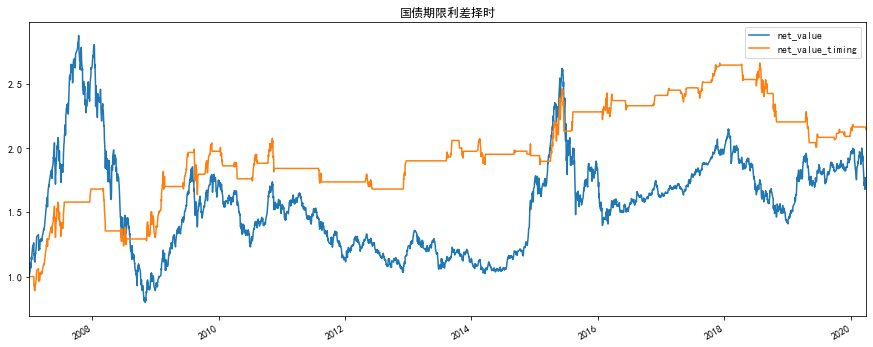

In [12]:
#期限利差择时
df_termspread=pd.DataFrame()
col='termspread'
df_termspread=term_spread_gz.to_frame('termspread')
upperband,middleband,lowerband = (tl.BBANDS(df_termspread[col].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
# print df_termspread

df_termspread['BBAND_upper']=upperband
df_termspread['BBAND_middle']=middleband
df_termspread['BBAND_lower']=lowerband
# df_termspread
df_termspread.head()
pre_position = 0
for date in df_termspread.index:
    if df_termspread.loc[date,col]<df_termspread.loc[date,'BBAND_middle']:
        df_termspread.loc[date,'position']=0
    elif df_termspread.loc[date,col]>df_termspread.loc[date,'BBAND_upper']:
        df_termspread.loc[date,'position']=1.0
    else:
        df_termspread.loc[date,'position']=pre_position
    pre_position=df_termspread.loc[date,'position']
df_termspread['position']=df_termspread['position'].shift(1)
df_termspread.head().append(df_termspread.tail())

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2020-03-31',fields='close')['close']
df_pct['pct']=prices.pct_change()

rate_riskfree = 0
df_pct = pd.concat([df_pct,df_termspread],axis=1)['2007-01-01':'2020-03-31'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='国债期限利差择时')

In [13]:
df_termspread.tail(10)

,termspread,BBAND_upper,BBAND_middle,BBAND_lower,position
日期,,,,,
2020-04-02,1.4854,1.391378,1.138332,0.885286,1.0
2020-04-03,1.5275,1.442921,1.157024,0.871127,1.0
2020-04-07,1.5242,1.486903,1.174604,0.862305,1.0
2020-04-08,1.4303,1.511424,1.187892,0.864360,1.0
2020-04-09,1.5005,1.543515,1.205380,0.867245,1.0
2020-04-10,1.5122,1.574108,1.222756,0.871404,1.0
2020-04-13,1.5549,1.606944,1.243076,0.879208,1.0
2020-04-14,1.6509,1.641837,1.273004,0.904171,1.0
2020-04-15,1.6968,1.683820,1.301280,0.918740,1.0


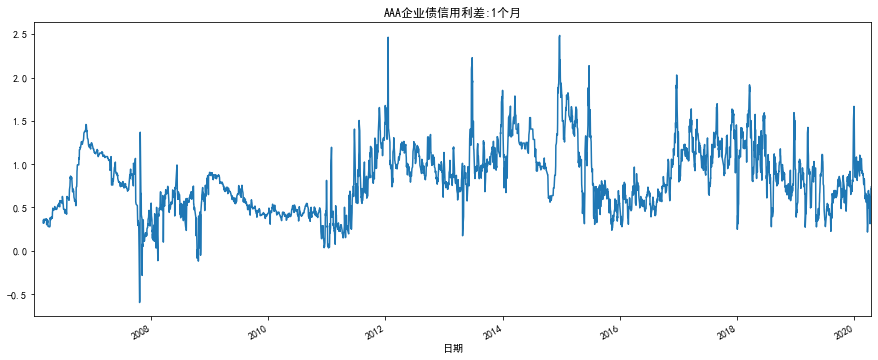

In [14]:
#获取信用利差数据
body=read_file(path+'/企业债到期收益率(AAA).xls')
df_qyz=pd.read_excel(BytesIO(body))
df_qyz.set_index(u'日期',inplace=True)
df_qyz=df_qyz.fillna(method='ffill')

credit_spread = df_qyz[u'中债企业债到期收益率(AAA):1个月']-df_gz[u'中债国债到期收益率:1个月']

credit_spread=credit_spread.rolling(1).mean()
credit_spread['2006-01-01':].plot(figsize=(15,6),title='AAA企业债信用利差:1个月')

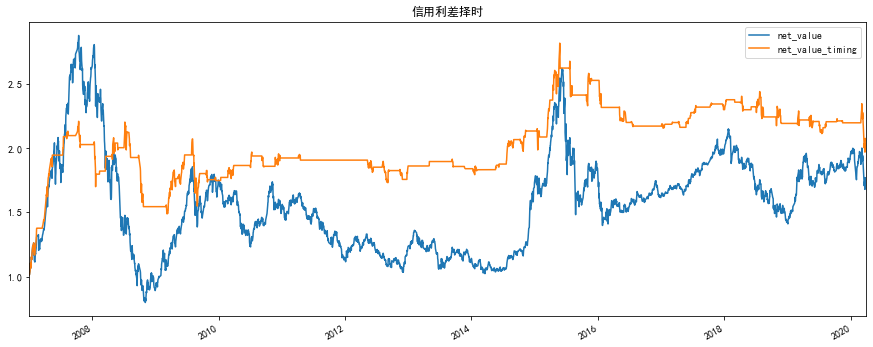

In [16]:
#信用利差择时
df_creditspread=pd.DataFrame()
col='creditspread'
df_creditspread=credit_spread.to_frame('creditspread')
upperband,middleband,lowerband = (tl.BBANDS(df_creditspread[col].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))

df_creditspread['BBAND_upper']=upperband
df_creditspread['BBAND_middle']=middleband
df_creditspread['BBAND_lower']=lowerband
pre_position = 0
for date in df_creditspread.index:
    if df_creditspread.loc[date,col]>df_creditspread.loc[date,'BBAND_middle']:
        df_creditspread.loc[date,'position']=0
    elif df_creditspread.loc[date,col]<df_creditspread.loc[date,'BBAND_lower']:
        df_creditspread.loc[date,'position']=1.0
    else:
        df_creditspread.loc[date,'position']=pre_position
    pre_position=df_creditspread.loc[date,'position']
df_creditspread['position']=df_creditspread['position'].shift(1)

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2020-03-31',fields='close')['close']
df_pct['pct']=prices.pct_change()

rate_riskfree =0
df_pct = pd.concat([df_pct,df_creditspread],axis=1)['2007-01-01':'2020-03-31'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='信用利差择时')



In [17]:
df_creditspread.tail(10)

,creditspread,BBAND_upper,BBAND_middle,BBAND_lower,position
日期,,,,,
2020-04-02,0.6448,0.882357,0.605488,0.328619,0.0
2020-04-03,0.6509,0.871029,0.600556,0.330083,0.0
2020-04-07,0.5429,0.856328,0.591804,0.327280,0.0
2020-04-08,0.3119,0.837938,0.571004,0.304070,0.0
2020-04-09,0.3430,0.815320,0.552192,0.289064,0.0
2020-04-10,0.4635,0.797510,0.541380,0.285250,0.0
2020-04-13,0.5901,0.785373,0.536428,0.287483,0.0
2020-04-14,0.7115,0.796664,0.540960,0.285256,0.0
2020-04-15,0.7103,0.804733,0.544036,0.283339,0.0


Index(['社会融资规模:当月值', 'M1:同比', 'M2:同比'], dtype='object')


E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  app.launch_new_instance()


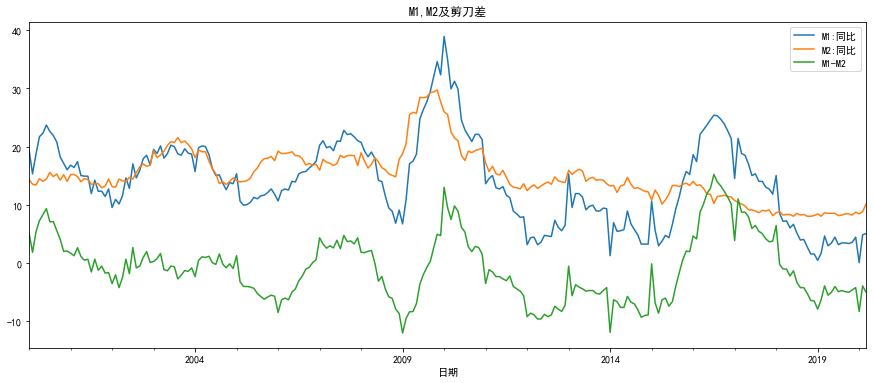

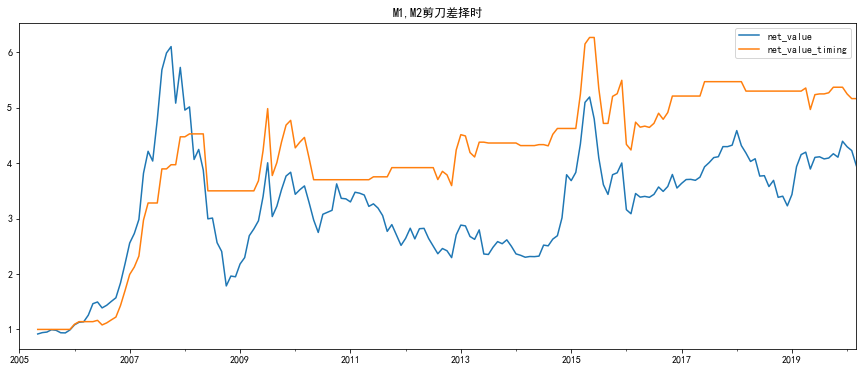

In [19]:
#M1,M2剪刀差择时
body=read_file(path+'/信贷.xls')
df_credit_loan_1=pd.read_excel(BytesIO(body))
df_credit_loan_1=df_credit_loan_1.set_index(u'日期')
print (df_credit_loan_1.columns)
col = u'社会融资规模:当月值'
col_1 = u'M1:同比'
col_2 = u'M2:同比'
# col = col_1
col = u'M1-M2'
df_credit_loan_1[u'M1-M2'] = df_credit_loan_1[u'M1:同比']-df_credit_loan_1[u'M2:同比']
n=3
df_credit_loan_1.iloc[:,1:].plot(figsize=(15,6),title='M1,M2及剪刀差')
df_credit_loan_1['position']=df_credit_loan_1[col].shift(2).rolling(n).mean()>df_credit_loan_1[col].shift(3).rolling(n).mean()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2020-03-31',fields='close')['close']
prices_M = prices.resample('M',how='last')

rate_riskfree = 0#(1+1.25e-4)**21.0-1

df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_credit_loan_1['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='M1,M2剪刀差择时')

Index(['社会融资规模:当月值', 'M1:同比', 'M2:同比'], dtype='object')


E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  del sys.path[0]


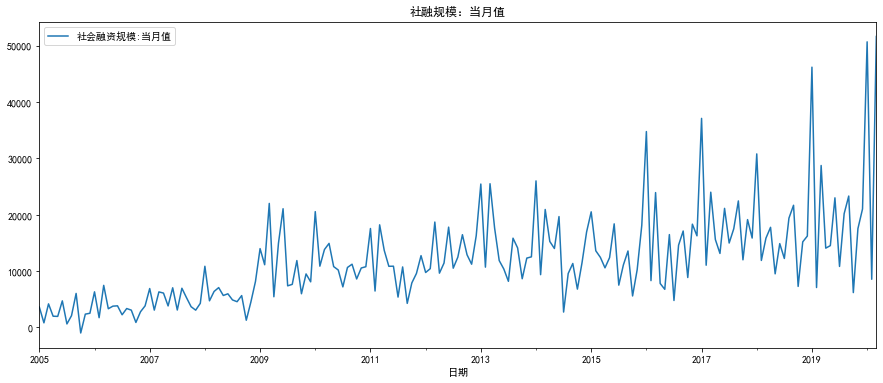

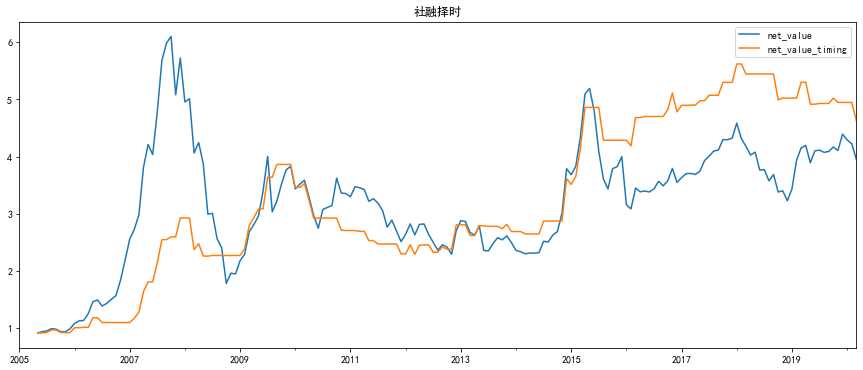

In [21]:
#社融择时
body=read_file(path+'/信贷.xls')
df_credit_loan_2=pd.read_excel(BytesIO(body))
df_credit_loan_2=df_credit_loan_2.set_index(u'日期')
print (df_credit_loan_2.columns)
col = u'社会融资规模:当月值'
col_1 = u'M1:同比'
col_2 = u'M2:同比'
n=3
df_credit_loan_2.iloc[:,:1].rolling(1).mean()['2005-01-01':].plot(figsize=(15,6),title='社融规模：当月值')
df_credit_loan_2['position']=df_credit_loan_2[col].shift(2).rolling(n).mean()>df_credit_loan_2[col].shift(3).rolling(n).mean()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2020-03-31',fields='close')['close']
prices_M = prices.resample('M',how='last')

rate_riskfree = 0#(1+1.25e-4)**21.0-1

df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_credit_loan_2['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='社融择时')

Index(['年度累计', '同比增长率(%)', '当月'], dtype='object')


E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:13: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  del sys.path[0]


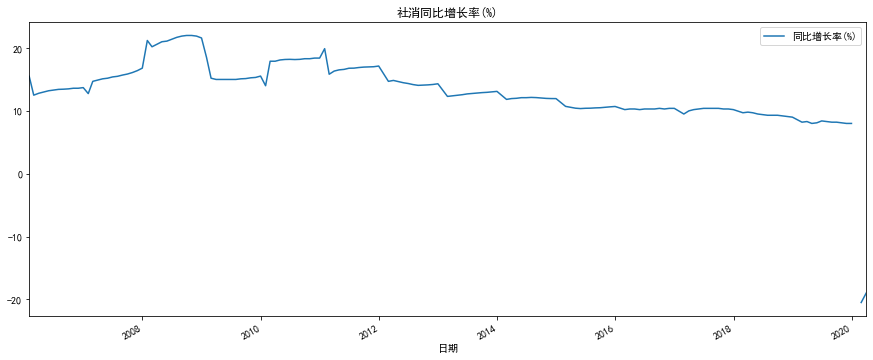

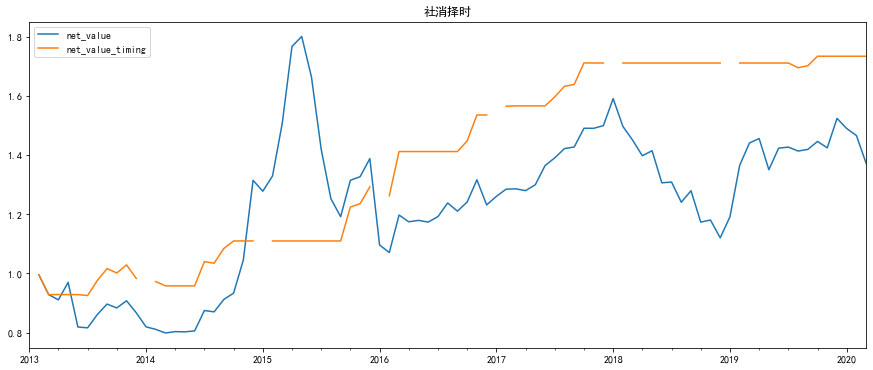

In [22]:
#社消总额
body=read_file(path+'/社消总额.xls')
df_Total_Retail_Sales=pd.read_excel(BytesIO(body))
df_Total_Retail_Sales=df_Total_Retail_Sales.set_index(u'日期')
print (df_Total_Retail_Sales.columns)
col = u'同比增长率(%)'
#col_1 = u'M1:同比'
#col_2 = u'M2:同比'
n=3
df_Total_Retail_Sales.iloc[:,1:2].rolling(1).mean()['2006-01-01':].plot(figsize=(15,6),title='社消同比增长率(%)')
df_Total_Retail_Sales['position']=df_Total_Retail_Sales[col].shift(2).rolling(n).mean()>df_Total_Retail_Sales[col].shift(3).rolling(n).mean()
prices = get_price('000300.XSHG',start_date='2013-01-01',end_date='2020-03-31',fields='close')['close']
prices_M = prices.resample('M',how='last')

rate_riskfree = 0#(1+1.25e-4)**21.0-1

df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_Total_Retail_Sales['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='社消择时')

E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  if __name__ == '__main__':


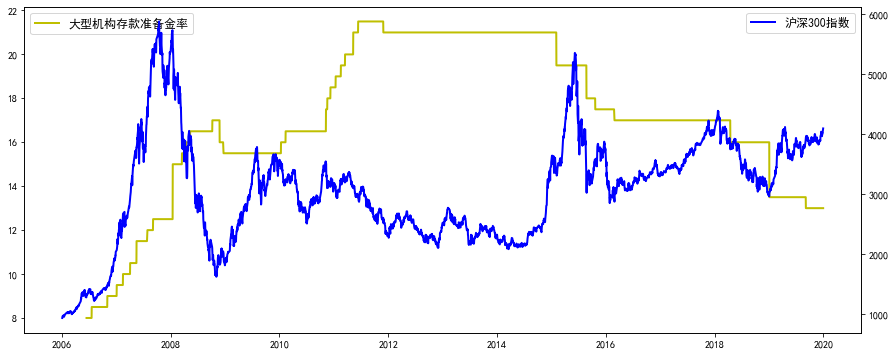

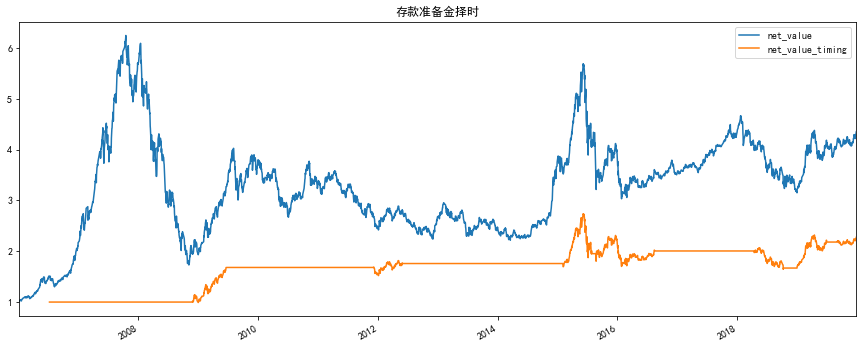

In [27]:
#存款准备金择时
body=read_file(path+'/存款准备金率-大型存款类机构.xls')
df_reserves=pd.read_excel(BytesIO(body))
df_reserves = df_reserves.set_index(u'日期')
df_reserves
col=u'人民币存款准备金率:大型存款类金融机构'
df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2020-01-01',fields='close')['close']
prices_M = prices.resample('M',how='last')
df_pct['pct']=prices.pct_change()
df_pct
rate_riskfree=0
# df_reserves['position']=df_reservesdf_reserves
df_reserves=df_reserves.reindex(prices.index).fillna(method='ffill')
# df_reserves[col].plot(figsize=(15,6))
# df_reserves['position'].plot(figsize=(15,6))
fig = plt.figure(figsize=(15,6))
# fig = plt.grid(False)
ax1=fig.add_subplot(111)
ax1.plot(df_reserves[col],'y-',linewidth=2,label='大型机构存款准备金率')
ax1.legend(loc=2,fontsize=12)
ax2=ax1.twinx()#这是双坐标关键一步
ax2.plot(prices,'b-',linewidth=2,label='沪深300指数')
ax2.legend(loc=1,fontsize=12)
# ax1.grid(False)
ax2.grid(False)
plt.show()

pre_position=0
delay_days=120
for i in range(delay_days,len(df_reserves)):
    pre_index = df_reserves.index[i-delay_days]
    index = df_reserves.index[i]
#     print df_reserves.loc[index,col]
    if df_reserves.loc[index,col]<df_reserves.loc[pre_index,col]:
        df_reserves.loc[index,'position']=1
    elif df_reserves.loc[index,col]>df_reserves.loc[pre_index,col]:
        df_reserves.loc[index,'position']=0.
    else:
        df_reserves.loc[index,'position']=0.
    pre_position = df_reserves.loc[index,'position']
df_pct['position'] = df_reserves['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='存款准备金择时')

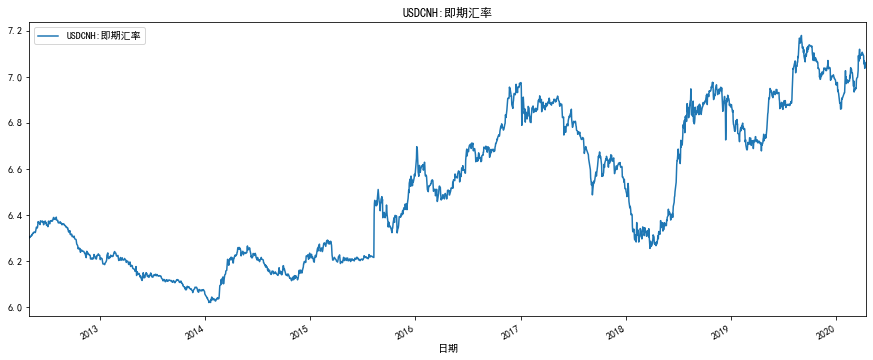

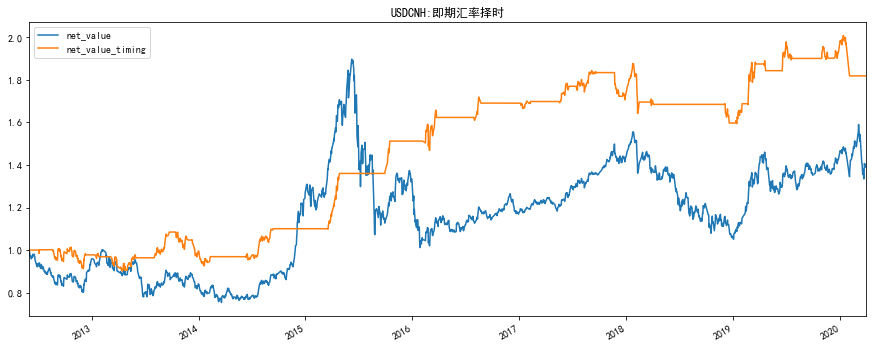

In [29]:
#USDCNH:即期汇率择时
body=read_file(path+'/离岸汇率数据.xls')
df_exchange_rate=pd.read_excel(BytesIO(body))
col = u'USDCNH:即期汇率'
df_exchange_rate=df_exchange_rate.set_index(u'日期')
df_exchange_rate.plot(figsize=(15,6),title='USDCNH:即期汇率')

upperband,middleband,lowerband = (tl.BBANDS(df_exchange_rate[col].values, timeperiod=25, nbdevup=1.8, nbdevdn=1.8))
df_exchange_rate['BBAND_upper']=upperband
df_exchange_rate['BBAND_middle']=middleband
df_exchange_rate['BBAND_lower']=lowerband
df_exchange_rate.head()
pre_position = 0
for date in df_exchange_rate.index:
    if df_exchange_rate.loc[date,col]>df_exchange_rate.loc[date,'BBAND_middle']:
        df_exchange_rate.loc[date,'position']=0
    elif df_exchange_rate.loc[date,col]<df_exchange_rate.loc[date,'BBAND_lower']:
        df_exchange_rate.loc[date,'position']=1.0
    else:
        df_exchange_rate.loc[date,'position']=pre_position
    pre_position=df_exchange_rate.loc[date,'position']
df_exchange_rate['position']=df_exchange_rate['position'].shift(1)
df_exchange_rate.head().append(df_exchange_rate.tail())

df_pct=pd.DataFrame()
prices = get_price('000300.XSHG',start_date='2005-01-01',end_date='2020-03-31',fields='close')['close']
df_pct['pct']=prices.pct_change()
df_pct = pd.concat([df_pct,df_exchange_rate],axis=1)['2007-01-01':'2020-03-31'].dropna()
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='USDCNH:即期汇率择时')

Index(['日期', 'CPI:当月同比', '预测平均值:CPI:当月同比', 'PPI:全部工业品:当月同比', '预测平均值:PPI:当月同比'], dtype='object')


E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:26: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()


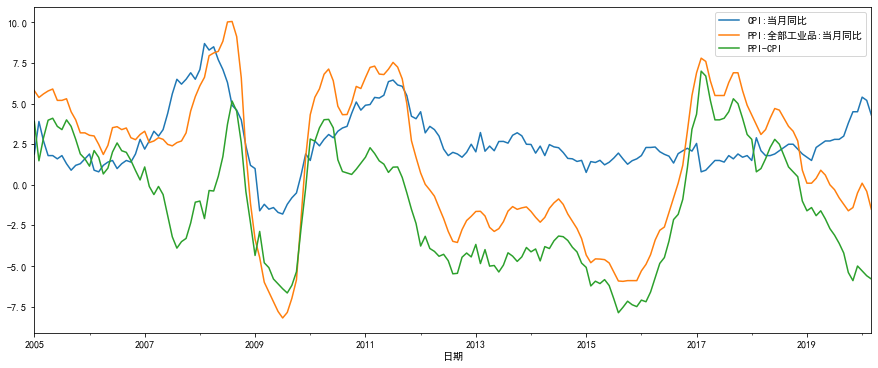

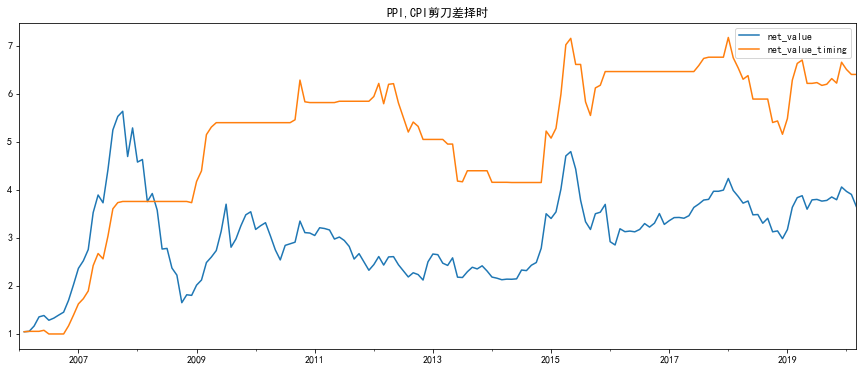

In [30]:
#通胀指数择时
#ppi cpi剪刀差同样预示后期销售净利率的受挫
body=read_file(path+'/CPI与PPI.xls')
df_inflation=pd.read_excel(BytesIO(body))
print (df_inflation.columns)
col_0 =u'CPI:当月同比'
col_1 =u'PPI:全部工业品:当月同比'
df_inflation=df_inflation.set_index(u'日期')['2005-01-31':]
col_2 = u'PPI-CPI'
df_inflation[col_2] = -df_inflation[u'CPI:当月同比']+df_inflation[u'PPI:全部工业品:当月同比']
df_inflation[[col_0,col_1,col_2]].plot(figsize=(15,6))
def good_cpi(x):
    if x<0:
        y=0.
    elif x<5.:
        y=1.
    else:
        y=0
    return y
    
n=3
df_inflation['position']=(df_inflation[col_2].shift(2).rolling(n).mean()<df_inflation[col_2].shift(3).rolling(n).mean())*\
    (df_inflation[col_0].apply(good_cpi).shift(2).rolling(n).mean())

prices = get_price('000300.XSHG',start_date='2006-01-01',end_date='2020-03-31',fields='close')['close']
prices_M = prices.resample('M',how='last')

rate_riskfree = 0#(1+1.25e-4)**20.0-1
df_pct=pd.DataFrame()
df_pct['pct']=prices_M.pct_change()
df_pct['position']=df_inflation['position']
df_pct['net_value'] =(df_pct['pct']+1).cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1).cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='PPI,CPI剪刀差择时')

In [32]:
import datetime
def dateRange(beginDate, endDate):
    dates = []
    dt=beginDate
    date = beginDate
    while date <= endDate:
        dates.append(date)
        dt = dt + datetime.timedelta(1)
        date = dt
    return dates
date_list = dateRange(prices_M.index[0],prices_M.index[-1])
len(date_list)


5174

E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:43: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:39: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
E:\Anaconda\envs\flask1\lib\site-packages\pandas\core\indexing.py:961: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#ix-indexer-is-deprecated
  return getattr(section, self.name)[new_key]
E:\Anaconda\envs\flask1\lib\site-packages\ipykernel_launcher.py:40: FutureWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documenta

最大回测为：
0.004752170657167598
夏普率为：
0.9473190293840323
年化收益为：
0.0627540272146836


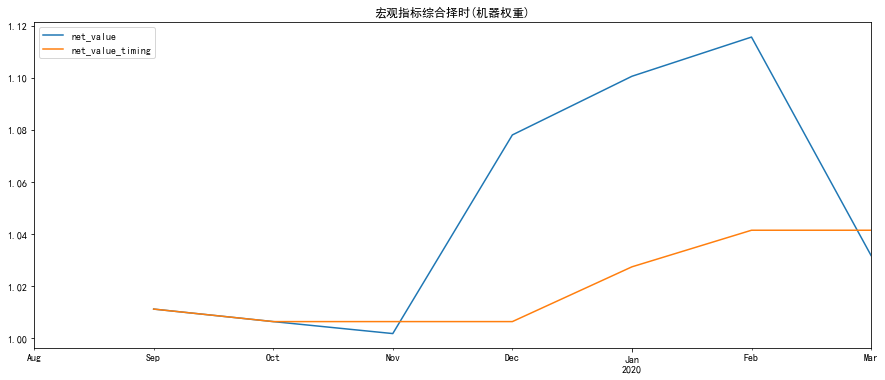

In [37]:
#汇总以上宏观指标
df_interest_M = df_interest['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#利率
df_termspread_M = df_termspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#期限利差
df_creditspread_M = df_creditspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#信用利差
df_reserves_M = df_reserves['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
# df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1

df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1       #+ df_reserves_M*0.33

df_monetray[df_monetray>1]=1

#df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1
#货币政策择时指标=利率+期限利差+信用利差
df_forex = (df_exchange_rate['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1))
#汇率


df_credit_loan = ((df_credit_loan_1['position']*1+df_credit_loan_2['position']*1)/2.)*1 
df_credit_loan = df_credit_loan + df_reserves_M*0.3
df_credit_loan[df_credit_loan>1]=1
#信贷择时指标=M1,M2剪刀差+社融指标+降准


df_total_retail_sales = df_Total_Retail_Sales['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#社消

df_month=pd.concat([df_monetray,df_forex,df_credit_loan,\
                  df_boom['position'],df_inflation['position'], df_Total_Retail_Sales['position']],axis=1)
factor_columns = ['monetary','forex','credit','boom','inflation','retail_sales']#货币政策，汇率，信贷，经济增长，通货膨胀,社消总额
df_month.columns = factor_columns
#weight_f=([0.5,0.7,0.9,0.5,0.5,0.9]) #六大类指标权重，增大信贷指标的权重(暂时最佳)
#weight_f=([0.5,0.7,0.1,0.1,0.7,0.8]) #15到19的最优解
weight_f=([0.2, 0.5, 0.2, 0.2, 0.6000000000000001, 0.7000000000000001])
timing_count=((df_month[factor_columns]>=0)*weight_f).sum(axis=1)
#每一期（月度）的满分（由于早期有些指标为NAN，因此满分不为1）
df_month['tot_pos'] = ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.55)*0.5+\
    ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.45)*0.5
#根据每一期得分占满分的比例做出仓位决策
prices = get_price('000905.XSHG',start_date='2019-08-01',end_date='2020-03-31',fields='close')['close']
prices_M = prices.resample('M',how='last')
rate_riskfree = 0   #年化收益2.59%
df_pct=pd.DataFrame()
start_date='2005-01-01'
df_pct['pct']=prices_M.pct_change()[start_date:]
df_pct['position']=df_month['tot_pos']
df_pct['net_value'] =(df_pct['pct']+1)[start_date:].cumprod()
df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1)[start_date:].cumprod()
df_pct[['net_value','net_value_timing']].plot(figsize=(15,6),title='宏观指标综合择时(机器权重)')
print('最大回测为：')
print (backtest_result(df_pct['net_value_timing']).Max_Drawback())#最大回撤
print('夏普率为：')
print (backtest_result(df_pct['net_value_timing']).Sharpe())#夏普率
print('年化收益为：')
print (backtest_result(df_pct['net_value_timing']).annualized_returns)#年化收益

In [ ]:
#train
#汇总以上宏观指标
df_interest_M = df_interest['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#利率
df_termspread_M = df_termspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#期限利差
df_creditspread_M = df_creditspread['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#信用利差
df_reserves_M = df_reserves['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
# df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1

df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1       
#+ df_reserves_M*0.33出去了存款准备金率影响

df_monetray[df_monetray>1]=1

#df_monetray = ((df_interest_M*1 + df_termspread_M*1 + df_creditspread_M*1)/3.)*1
#货币政策择时指标=利率+期限利差+信用利差
df_forex = (df_exchange_rate['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1))
#汇率


df_credit_loan = ((df_credit_loan_1['position']*1+df_credit_loan_2['position']*1)/2.)*1 
df_credit_loan = df_credit_loan #+ df_reserves_M*0.3
df_credit_loan[df_credit_loan>1]=1
#信贷择时指标=M1,M2剪刀差+社融指标+降准


df_total_retail_sales = df_Total_Retail_Sales['position'].reindex(date_list).fillna(method='ffill').reindex(prices_M.index).shift(1)
#社消

df_month=pd.concat([df_monetray,df_forex,df_credit_loan,\
                  df_boom['position'],df_inflation['position'], df_Total_Retail_Sales['position']],axis=1)
factor_columns = ['monetary','forex','credit','boom','inflation','retail_sales']#货币政策，汇率，信贷，经济增长，通货膨胀,社消总额
df_month.columns = factor_columns
temp = -100
w1=w2=w3=w4=w5=w6=0
weight_f=([w1,w2,w3,w4,w5,w6]) #六大类指标权重，增大信贷指标的权重
for w1 in np.arange(0,0.5,0.1):
    print(1)
    for w2 in np.arange(0,1,0.1):
        print(2)
        for w3 in np.arange(0,1,0.1):
            print(3)
            for w4 in np.arange(0,1,0.1):
                for w5 in np.arange(0,1,0.1):
                    for w6 in np.arange(0,1,0.1):
                        weight_f=([w1,w2,w3,w4,w5,w6])
                        #print(weight_f)
                        timing_count=((df_month[factor_columns]>=0)*weight_f).sum(axis=1)
                        #每一期（月度）的满分（由于早期有些指标为NAN，因此满分不为1）
                        df_month['tot_pos'] = ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.55)*0.5+\
                            ((df_month[factor_columns]*weight_f).sum(axis=1)/timing_count>0.45)*0.5
                        #根据每一期得分占满分的比例做出仓位决策
                        prices = get_price('000905.XSHG',start_date='2015-01-01',end_date='2019-12-31',fields='close')['close']
                        prices_M = prices.resample('M',how='last')
                        rate_riskfree = 0   #年化收益2.59%
                        df_pct=pd.DataFrame()
                        start_date='2015-01-01'
                        df_pct['pct']=prices_M.pct_change()[start_date:]
                        df_pct['position']=df_month['tot_pos']
                        df_pct['net_value'] =(df_pct['pct']+1)[start_date:].cumprod()
                        df_pct['net_value_timing'] = (df_pct['pct']*df_pct['position']+rate_riskfree*(1-df_pct['position'])+1)[start_date:].cumprod()
                        if temp<backtest_result(df_pct['net_value_timing']).Sharpe():
                            temp = backtest_result(df_pct['net_value_timing']).Sharpe()
                            print('最大回测为：')
                            print (backtest_result(df_pct['net_value_timing']).Max_Drawback())#最大回撤
                            print('夏普率为：')
                            print (backtest_result(df_pct['net_value_timing']).Sharpe())#夏普率
                            print('年化收益为：')
                            print (backtest_result(df_pct['net_value_timing']).annualized_returns)#年化收益
                            print(weight_f)
